In [ ]:
__author__ = "Yuqiao(Echo) Zhong"
__email__ = "yuqiao.zhong@simon.rochester.edu"
__website__ = "https://www.linkedin.com/in/yuqiaoechozhong/"

# Part 1 - Introduction
My ultimate goal for this project is to predict whether a Yelp review is 1 star or 5 star based on the text content. I took a machine learning course taught by Jose Portilla on Udemy. And now I want to apply what I learned into a new project. 

First I vectorized text messages into a form that machine learning algorithms can understand. Next I train a machine learning model to learn to discriminate between 1 star and 5 star messages. Finally, with the trained model, I will classify the reviews into 1 star or 5 star.

Dataset Informatiom
The yelp review dataset is obtained from Kaggle dataset (https://www.kaggle.com/c/yelp-recsys-2013Each). Each observation in this dataset is a review of a particular business by a particular user.
The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review. The "cool" column is the number of "cool" votes this review received from other Yelp users. The "useful" and "funny" columns are similar to the "cool" column.

# Part 2 - Exploratory Data Analysis

**Import the libraries**

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Load the data**

In [5]:
yelp = pd.read_csv('yelp.csv')
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


**Create a new column to record the length of each review**

In [7]:
yelp['text length'] = yelp['text'].apply(len)

**Let's use FacetGrid to create a grid of 5 histograms of text length based off of the star ratings**

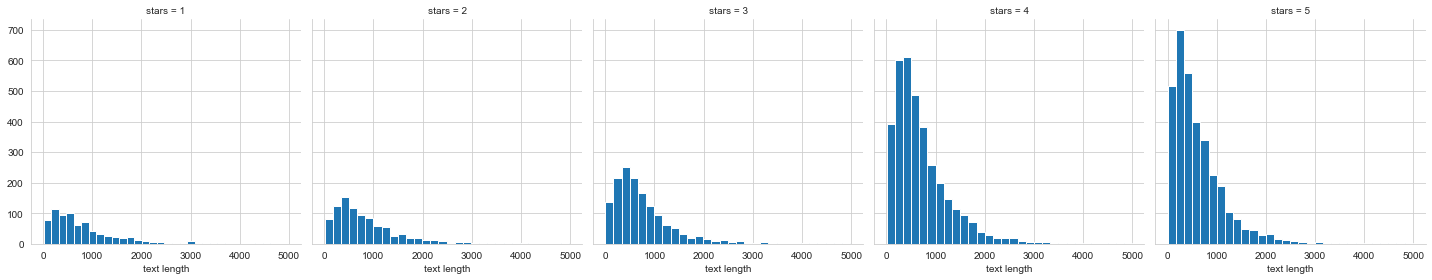

In [8]:
sns.set_style('whitegrid')
length_hist = sns.FacetGrid(yelp, col="stars", height=4)
length_hist.map(plt.hist, "text length", bins=30)

From the length distribution plots, it seems like most reviews are around 500 words. There are much more reviews in the 4 and 5 stars reviews. But let's further explore if there is any outliers.

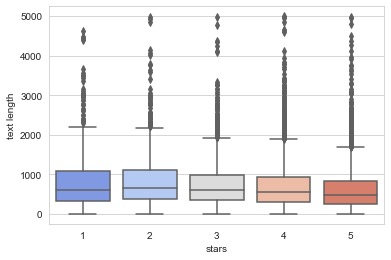

In [11]:
sns.boxplot(x='stars',y='text length',data=yelp, palette='coolwarm')

Interesting finding, 5 star review actually has the least amount of text but a lot of outliers. There are about 6 of them are over 4000 words. What are they? 

In [33]:
for message in yelp[(yelp['stars']==5) & (yelp['text length']>4000)]['text']:
    print (message,"\n\n")

FINALMENTE!!!

Andiamo....

FOOD
--------
Appetizer: Fritto Misto, which is a trio of fried appetizers. For the day, ours included a cheese, a stuffed olive, and whole leaves of broccolini. The cheese wedge was great (I wish I remembered what it was), and have you ever had a deep fried veal-stuffed olive? Very interesting. The flash-fried broccolini took a little getting used to, since the leaves kept crumbling as I was trying to eat them, but still tasty, if subtle.

Main: Orecchiette alla Puttanesca. Man. This is the real deal. Orecchiette is the "little ear" pasta and "alla puttanesca" means it's made "whore style". 

And what a beautiful, classy, yet very vibrant whore she is.

The pasta was cooked just perfectly, and even though puttanesca sauce usually goes with a stringier pasta (spaghetti, linguini, etc.) it worked really well with the orecchiette. 

And the sauce. Holy mother, this streetwalkin' hussy of a sauce with its 12 ingredients: capers, breadcrumbs, anchovy sauce, garl

Interesting value added story, but let's get back and see how many reviews are in each star.

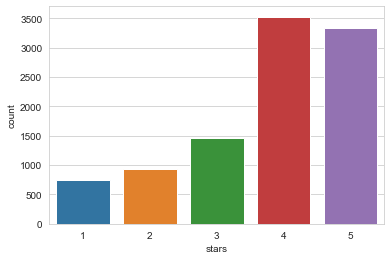

In [34]:
sns.countplot(yelp['stars'])

The dataset contains mostly 4 star review. Now let's take a look at a mean value for all the columns for each star and see if we can find any correlation.

In [37]:
stars_stats = yelp.groupby('stars').mean()
stars_stats

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


Higher reviews tend to have shorter text length and lower funny attributes. This makes sense because usually the good reviews just describe how good the restaurant is and tend not to be humorous.
Vice versa, lower reviews tend to have longer text length and higher useful attributes.

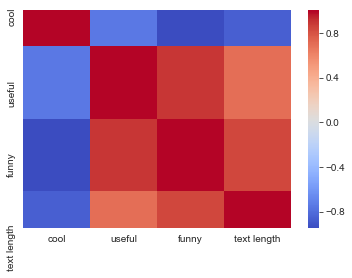

In [42]:
sns.heatmap(stars_stats.corr(),cmap='coolwarm')

A cool message tends to be not so funny; and a funny review tends to be more useful. These are all just correlations.

**From the EDA process, we can conclude the dataset contains a higher portion of 4 and 5 star reviews. As of length, all the reviews tend to have text length at around 600-800. Higher review have shorter length and lower funny attributes, while bad reviews tend to have longer lenth and higher useful attribute and lower cool attribute.**

# Part 3 - NLP Classification Task

**First, let's clean the data and remove the punctuation and stop words in the text.**

In [64]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuqiaozhong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [72]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [74]:
yelp['text'].apply(text_process)

0       [wife, took, birthday, breakfast, excellent, w...
1       [idea, people, give, bad, reviews, place, goes...
2       [love, gyro, plate, Rice, good, also, dig, can...
3       [Rosie, Dakota, LOVE, Chaparral, Dog, Park, co...
4       [General, Manager, Scott, Petello, good, egg, ...
                              ...                        
9995    [First, visitHad, lunch, today, used, Groupon,...
9996    [called, house, deliciousness, could, go, item...
9997    [recently, visited, Olive, Ivy, business, last...
9998    [nephew, moved, Scottsdale, recently, bunch, f...
9999    [45, locations, 45, star, average, think, Ariz...
Name: text, Length: 10000, dtype: object

**Now we have the text data ready to be analyzed, let's split the data into training and test dataset.** 

First, let's only look at 1-star and 5-star data.

In [95]:
yelp_class=yelp[(yelp.stars==1) | (yelp.stars==5)]

In [101]:
from sklearn.model_selection import train_test_split
X=yelp_class['text']
y=yelp_class['stars']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

**Next, let's create a pipeline to train the model. The pipeline will consist of three parts:**

**1) Vectorize the processed text message to integer counts**

**2) Weight the counts to TF-IDF scores**

**3) Train the model with Naive Bayes classifier.**

In [86]:
from sklearn.feature_extraction.text import CountVectorizer # vectorize the text
from sklearn.feature_extraction.text import TfidfTransformer # weight the counts
from sklearn.naive_bayes import MultinomialNB # Use naive bayes model to train and predict the data

In [87]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

**Ok, let's train and fit the data!**

In [102]:
pipeline.fit(X_train,y_train)
prediction = pipeline.predict(X_test)

# Evaluate the model

In [103]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,prediction))
print('\n\n')
print(classification_report(y_test,prediction))

[[  0 228]
 [  0 998]]



              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The results are not very good. Let's try not including the Tfidf method. 

In [104]:
from sklearn.pipeline import Pipeline
pipeline2 = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts  
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [105]:
pipeline2.fit(X_train,y_train)
prediction = pipeline2.predict(X_test)

In [106]:
print(confusion_matrix(y_test,prediction))
print('\n\n')
print(classification_report(y_test,prediction))

[[143  85]
 [ 11 987]]



              precision    recall  f1-score   support

           1       0.93      0.63      0.75       228
           5       0.92      0.99      0.95       998

    accuracy                           0.92      1226
   macro avg       0.92      0.81      0.85      1226
weighted avg       0.92      0.92      0.92      1226



# Part 4 - Conclusion

Overall accuracy reaches 92%. 96 out of 1226 reviews are put in the wrong category. 

Before using machine learning techniques to identify reviews, I cleaned the dataset of 10000 messages obtained from Kaggle Yelp review dataset by removing punctuation and stop words in each review. Then I choose the data which only contains 1 star and 5 star reviews to further train the data. I created a pipeline that vectorized the text messages, calculated TF-IDF of each vector, and train the data with Naive Bayes algorithm. However the model only reached accuracy rate of 81% overall.

I then remove the TF-IDF step from the whole process and re-calculate the accuracy and it turns out to be much higher to 92%. 

This is just a very simple project to apply what I have learned of Natural Language Processing to a Kaggle dataset, but there are many other techniques that can enhance the process.